In [2]:
%pip list

Package                              Version
------------------------------------ --------------------
alabaster                            0.7.12
anaconda-client                      1.11.0
anaconda-project                     0.11.1
anyio                                3.5.0
appdirs                              1.4.4
argon2-cffi                          21.3.0
argon2-cffi-bindings                 21.2.0
arrow                                1.2.2
astroid                              3.0.0
astropy                              5.3.4
asttokens                            2.4.0
atomicwrites                         1.4.0
attrs                                23.1.0
Automat                              20.2.0
autopep8                             1.6.0
autovizwidget                        0.21.0
awscli                               1.29.63
Babel                                2.9.1
backcall                             0.2.0
backports.functools-lru-cache        1.6.4
backports.tempfile         

## Notebook License

## MIT No Attribution

Copyright 2022 COPYRIGHT Amazon Web Services Ltd.  

Permission is hereby granted, free of charge, to any person obtaining a copy of this
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify,
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
permit persons to whom the Software is furnished to do so.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Autogluon License

Copyright 2022 Amazon Web Services Ltd.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Predicting Air Quality with Amazon Sustainability Data Initiative using NOAA + OpenAQ Datasets

This demo consists of a Jupyter Notebook that connects to Amazon Sustainability Data Initiative (ASDI) datasets from NOAA and OpenAQ to build a Machine Learning (ML) model to predict air quality levels using weather data via a Binary Classification AutoGluon model. The project's purpose is to demonstrate using two different types of ASDI datasets (files in Amazon S3 and HTTPS APIs) within a Jupyter Notebook, such as provided by Amazon SageMaker Studio. This demo is NOT for scientific or health purposes.

In [3]:
%pip install --quiet --upgrade pip

%pip install --quiet ipywidgets

%pip install --quiet autogluon

%pip install --quiet PyAthena

%pip show autogluon

%pip show ipywidgets

%pip show PyAthena

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
jupyterlab 3.4.4 requires jupyter-server~=1.16, but you have jupyter-server 2.7.3 which is incompatible.
jupyterlab-server 2.10.3 requires jupyter-server~=1.4, but you have jupyter-server 2.7.3 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.
spyder 5.3.3 requires ipython<8.0.0,>=7.31.1, but you have ipython 8.16.1 which is incompatible.
spyder 5.3.3 requires pylint<3.0,>=2.5.0, but you have pylint 3.0.1 which is incompatible.
spyder-kernels 2.3.3 requires ipython<8,>=7.31.1; python_version >= "3", but you have ipython 

In [4]:
# Import statements for packages used...
import glob
import json
import os
import shutil
import sys
from datetime import datetime
from io import StringIO
from types import SimpleNamespace

import boto3
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from autogluon.tabular import TabularPredictor
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import clear_output
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor

# The following is required for matplotlib plots to display in some envs...
%matplotlib inline

In [5]:
class AQParam:
    def __init__(self, id, name, unit, unhealthyThresholdDefault, desc):
        self.id = id
        self.name = name
        self.unit = unit
        self.unhealthyThresholdDefault = unhealthyThresholdDefault
        self.desc = desc

    def isValid(self):
        if (
            self is not None
            and self.id > 0
            and self.unhealthyThresholdDefault > 0.0
            and len(self.name) > 0
            and len(self.unit) > 0
            and len(self.desc) > 0
        ):
            return True
        else:
            return False

    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=2)


# class AQScenario => Defines an ML scenario including a Location w/ NOAA Weather Station ID
#                     and the target OpenAQ Param.
# Note: OpenAQ data mostly begins sometime in 2016, so using that as a default yearStart value.
class AQScenario:
    def __init__(
        self,
        location=None,
        noaaStationID=None,
        aqParamTarget=None,
        unhealthyThreshold=None,
        yearStart=2016,
        yearEnd=datetime.now().year,
        aqRadiusMiles=10,
        featureColumnsToDrop=None,
    ):
        self.location = location
        self.name = location + "_" + aqParamTarget.name
        self.noaaStationID = noaaStationID
        self.noaaStationLat = 0.0
        self.noaaStationLng = 0.0
        self.openAqLocIDs = []

        self.aqParamTarget = aqParamTarget

        if unhealthyThreshold and unhealthyThreshold > 0.0:
            self.unhealthyThreshold = unhealthyThreshold
        else:
            self.unhealthyThreshold = self.aqParamTarget.unhealthyThresholdDefault

        self.yearStart = yearStart
        self.yearEnd = yearEnd
        self.aqRadiusMiles = aqRadiusMiles
        self.aqRadiusMeters = (
            aqRadiusMiles * 1610
        )  # Rough integer approximation is fine here.

        self.modelFolder = "AutogluonModels"

    def getSummary(self):
        return f"Scenario: {self.name} => {self.aqParamTarget.desc} ({self.aqParamTarget.name}) with UnhealthyThreshold > {self.unhealthyThreshold} {self.aqParamTarget.unit}"

    def getModelPath(self):
        return f"{self.modelFolder}/aq_{self.name}_{self.yearStart}-{self.yearEnd}/"

    def updateNoaaStationLatLng(self, noaagsod_df_row):
        # Use a NOAA row to set Lat+Lng values used for the OpenAQ API requests...
        if (
            noaagsod_df_row is not None
            and noaagsod_df_row["LATITUDE"]
            and noaagsod_df_row["LONGITUDE"]
        ):
            self.noaaStationLat = noaagsod_df_row["LATITUDE"]
            self.noaaStationLng = noaagsod_df_row["LONGITUDE"]
            print(
                f"NOAA Station Lat,Lng Updated for Scenario: {self.name} => {self.noaaStationLat},{self.noaaStationLng}"
            )
        else:
            print("NOAA Station Lat,Lng COULD NOT BE UPDATED.")

    def isValid(self):
        if (
            self is not None
            and self.aqParamTarget is not None
            and self.yearStart > 0
            and self.yearEnd > 0
            and self.yearEnd >= self.yearStart
            and self.aqRadiusMiles > 0
            and self.aqRadiusMeters > 0
            and self.unhealthyThreshold > 0.0
            and len(self.name) > 0
            and len(self.noaaStationID) > 0
        ):
            return True
        else:
            return False

    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=2)


# class AQbyWeatherApp => Main app class with settings, AQParams, AQScenarios, and data access methods...
class AQbyWeatherApp:
    def __init__(
        self, mlTargetLabel="isUnhealthy", mlEvalMetric="accuracy", mlTimeLimitSecs=None
    ):
        self.mlTargetLabel = mlTargetLabel
        self.mlEvalMetric = mlEvalMetric
        self.mlTimeLimitSecs = mlTimeLimitSecs
        self.mlIgnoreColumns = [
            "DATE",
            "NAME",
            "LATITUDE",
            "LONGITUDE",
            "value"
        ]

        self.defaultColumnsNOAA = [
            "DATE",
            "NAME",
            "LATITUDE",
            "LONGITUDE",
            "DEWP",
            "WDSP",
            "MAX",
            "MIN",
            "PRCP",
            "MONTH",
            "VISIB",
            "SLP",
            "MXSPD"
        ]  # Default relevant NOAA columns
        self.defaultColumnsOpenAQ = [
            "day",
            "parameter",
            "unit",
            "average",
        ]  # Default relevant OpenAQ columns

        self.aqParams = {}  # A list to save AQParam objects
        self.aqScenarios = {}  # A list to save AQScenario objects

        self.selectedScenario = None

    def addAQParam(self, aqParam):
        if aqParam and aqParam.isValid():
            self.aqParams[aqParam.name] = aqParam
            return True
        else:
            return False

    def addAQScenario(self, aqScenario):
        if aqScenario and aqScenario.isValid():
            self.aqScenarios[aqScenario.name] = aqScenario
            if self.selectedScenario is None:
                self.selectedScenario = self.aqScenarios[
                    next(iter(self.aqScenarios))
                ]  # Default selectedScenario to 1st item.
            return True
        else:
            return False

    def getFilenameNOAA(self):
        if self and self.selectedScenario and self.selectedScenario.isValid():
            return f"dataNOAA_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}_{self.selectedScenario.noaaStationID}.csv"
        else:
            return ""

    def getFilenameOpenAQ(self):
        if (
            self
            and self.selectedScenario
            and self.selectedScenario.isValid()
            and len(self.selectedScenario.openAqLocIDs) > 0
        ):
            idString = ""
            for i in range(0, len(self.selectedScenario.openAqLocIDs)):
                idString = idString + str(self.selectedScenario.openAqLocIDs[i]) + "-"
            idString = idString[:-1]
            return f"dataOpenAQ_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}_{idString}.csv"
        else:
            return ""

    def getFilenameOther(self, prefix):
        if self and self.selectedScenario and self.selectedScenario.isValid():
            return f"{prefix}_{self.selectedScenario.name}_{self.selectedScenario.yearStart}-{self.selectedScenario.yearEnd}.csv"

    def getNoaaDataFrame(self):
        # ASDI Dataset Name: NOAA GSOD
        # ASDI Dataset URL : https://registry.opendata.aws/noaa-gsod/
        # NOAA GSOD README : https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt
        # NOAA GSOD data in S3 is organized by year and Station ID values, so this is straight-forward
        # Example S3 path format => s3://noaa-gsod-pds/{yyyy}/{stationid}.csv
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        noaagsod_df = pd.DataFrame()
        filenameNOAA = self.getFilenameNOAA()

        if os.path.exists(filenameNOAA):
            # Use local data file already accessed + prepared...
            print("Loading NOAA GSOD data from local file: ", filenameNOAA)
            noaagsod_df = pd.read_csv(filenameNOAA)
        else:
            # Access + prepare data and save to a local data file...
            noaagsod_bucket = "noaa-gsod-pds"
            print(
                f"Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: {noaagsod_bucket})..."
            )
            s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))

            for year in range(
                self.selectedScenario.yearStart, self.selectedScenario.yearEnd + 1
            ):
                key = f"{year}/{self.selectedScenario.noaaStationID}.csv"  # Compute the key to get
                csv_obj = s3.get_object(
                    Bucket=noaagsod_bucket, Key=key
                )  # Get the S3 object
                csv_string = (
                    csv_obj["Body"].read().decode("utf-8")
                )  # Read object contents to a string
                noaagsod_df = pd.concat(
                    [noaagsod_df, pd.read_csv(StringIO(csv_string))], ignore_index=True
                )  # Use the string to build the DataFrame

            # Perform some Feature Engineering to append potentially useful columns to our dataset... (TODO: Add more to optimize...)
            # It may be true that Month affects air quality (ie: seasonal considerations; tends to have correlation for certain areas)
            noaagsod_df["MONTH"] = pd.to_datetime(noaagsod_df["DATE"]).dt.month

            # Trim down to the desired key columns... (do this last in case engineered columns are to be removed)
            noaagsod_df = noaagsod_df[self.defaultColumnsNOAA]

        return noaagsod_df

    def getOpenAqDataFrame(self):
        # Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
        aq_df = pd.DataFrame()
        aq_reqUrlBase = "https://api.openaq.org/v2"  # OpenAQ ASDI API Endpoint URL Base (ie: add /locations OR /averages)

        if (
            self.selectedScenario.noaaStationLat == 0.0
            or self.selectedScenario.noaaStationLng == 0.0
        ):
            print("NOAA Station Lat/Lng NOT DEFINED. CANNOT PROCEED")
            return aq_df

        if len(self.selectedScenario.openAqLocIDs) == 0:
            # We must start by querying nearby OpenAQ Locations for their IDs...
            print("Accessing ASDI-hosted OpenAQ Locations (HTTPS API)...")
            aq_reqParams = {
                "limit": 10,
                "page": 1,
                "offset": 0,
                "sort": "desc",
                "order_by": "location",
                "parameter": self.selectedScenario.aqParamTarget.name,
                "coordinates": f"{self.selectedScenario.noaaStationLat},{self.selectedScenario.noaaStationLng}",
                "radius": self.selectedScenario.aqRadiusMeters,
                "isMobile": "false",
                "sensorType": "reference grade",
                "dumpRaw": "false",
            }
            aq_resp = requests.get(aq_reqUrlBase + "/locations", aq_reqParams)
            aq_data = aq_resp.json()
            if aq_data["results"] and len(aq_data["results"]) >= 1:
                
                for i in range(0, len(aq_data["results"])):
                    self.selectedScenario.openAqLocIDs.append(
                        aq_data["results"][i]["id"]
                    )
                print(
                    f"OpenAQ Location IDs within {self.selectedScenario.aqRadiusMiles} miles ({self.selectedScenario.aqRadiusMeters}m) "
                    + f"of NOAA Station {self.selectedScenario.noaaStationID} at "
                    + f"{self.selectedScenario.noaaStationLat},{self.selectedScenario.noaaStationLng}: {self.selectedScenario.openAqLocIDs}"
                )
            else:
                print(
                    f"NO OpenAQ Location IDs found within {self.selectedScenario.aqRadiusMiles} miles ({self.selectedScenario.aqRadiusMeters}m) "
                    + f"of NOAA Station {self.selectedScenario.noaaStationID}. CANNOT PROCEED."
                )

        if len(self.selectedScenario.openAqLocIDs) >= 1:
            filenameOpenAQ = self.getFilenameOpenAQ()
            if os.path.exists(filenameOpenAQ):
                # Use local data file already accessed + prepared...
                print("Loading OpenAQ data from local file: ", filenameOpenAQ)
                aq_df = pd.read_csv(filenameOpenAQ)
            else:
                # Extract data from Athena
                print("Accessing OpenAQ data via Athena")
                print("Please wait.... this may take several minutes")
                # convert the value of locations to string values and create a tuple
                locationids = tuple(str(x) for x in self.selectedScenario.openAqLocIDs)
                
                # Use Boto3 to get AccountId and save it in a variable
                account_id = boto3.client('sts').get_caller_identity().get('Account')
                
                # Connect to Athena
                cursor = connect(s3_staging_dir=f's3://airquality-athena-results-bucket-{account_id}',
                                 region_name='us-east-1').cursor()
                                
                # Execute the Athena Query
                cursor.execute(
                    f"""SELECT datetime,
                        parameter,
                        units,
                        value
                    FROM "OpenAQ"."openaq".{self.selectedScenario.location}
                    WHERE country = %(country)s
                        AND locationid in %(locationid)s
                        AND parameter = %(parameter)s;"""
                    ,{
                        "country": 'us',
                        "locationid": locationids,
                        "parameter": self.selectedScenario.aqParamTarget.name
                        }
                    )
                # get the results of the query in a dataframe with the column headings.
                df = pd.DataFrame(cursor.fetchall())
                df.columns = [desc[0] for desc in cursor.description]

                # convert the datetime column into the datetime datatype with utc=true
                df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

                # get only the date from the datetime column 
                df['date'] = pd.to_datetime(df['datetime']).dt.date

                # convert the value column to a float
                df['value'] = df['value'].astype(float)
                
                # Group the data by the date and calculate the average (mean) for value 
                aq_df = df.groupby('date')['value'].mean().reset_index()

                # Perform some Label Engineering to add our binary classification label => {0=OKAY, 1=UNHEALTHY}
                aq_df[self.mlTargetLabel] = np.where(aq_df["value"] <= self.selectedScenario.unhealthyThreshold, 0, 1)
        return aq_df

    def getMergedDataFrame(self, noaagsod_df, aq_df):
        if len(noaagsod_df) > 0 and len(aq_df) > 0:
            noaagsod_df["DATE"] = pd.to_datetime(noaagsod_df["DATE"])
            aq_df["date"] = pd.to_datetime(aq_df["date"])
            merged_df = pd.merge(
                noaagsod_df, aq_df, how="inner", left_on="DATE", right_on="date"
            )
            merged_df = merged_df.drop(columns=self.mlIgnoreColumns)
            return merged_df
        else:
            return pd.DataFrame()

    def getConfusionMatrixData(self, cm):
        cmData = SimpleNamespace()
        cmData.TN = cm[0][0]
        cmData.TP = cm[1][1]
        cmData.FN = cm[1][0]
        cmData.FP = cm[0][1]

        cmData.TN_Rate = cmData.TN / (cmData.TN + cmData.FP)
        cmData.TP_Rate = cmData.TP / (cmData.TP + cmData.FN)
        cmData.FN_Rate = cmData.FN / (cmData.FN + cmData.TP)
        cmData.FP_Rate = cmData.FP / (cmData.FP + cmData.TN)

        cmData.TN_Output = f"True Negatives  (TN): {cmData.TN} of {cmData.TN+cmData.FP} => {round(cmData.TN_Rate * 100, 2)}%"
        cmData.TP_Output = f"True Positives  (TP): {cmData.TP} of {cmData.TP+cmData.FN} => {round(cmData.TP_Rate * 100, 2)}%"
        cmData.FN_Output = f"False Negatives (FN): {cmData.FN} of {cmData.FN+cmData.TP} => {round(cmData.FN_Rate * 100, 2)}%"
        cmData.FP_Output = f"False Positives (FP): {cmData.FP} of {cmData.FP+cmData.TN} => {round(cmData.FP_Rate * 100, 2)}%"

        return cmData


print("Classes and Variables are ready.")

Classes and Variables are ready.


In [6]:
# Review the pre-defined AQParams and AQScenarios in this cell.
# AQParams are added with default thresholds, which can be overridden on a per-AQScenario basis.
# These AQParams are based on the OpenAQ /parameters API call where isCore=true (https://api.openaq.org/v2/parameters).
# Default thresholds where provided using data from EPA.gov (https://www.epa.gov/criteria-air-pollutants/naaqs-table).
# Confirm and adjust params or thresholds as needed for your needs... Not for scientific or health purposes.

# Instantiate main App class with explicit mlTargetLabel and mlEvalMetric provided...
AQbyWeather = AQbyWeatherApp(mlTargetLabel="isUnhealthy", mlEvalMetric="accuracy")

# Define and add new AQParams...
AQbyWeather.addAQParam(
    AQParam(1, "pm10", "µg/m³", 150.0, "Particulate Matter < 10 micrometers")
)
AQbyWeather.addAQParam(
    AQParam(2, "pm25", "µg/m³", 12.0, "Particulate Matter < 2.5 micrometers")
)
AQbyWeather.addAQParam(AQParam(7, "no2", "ppm", 100.0, "Nitrogen Dioxide"))
AQbyWeather.addAQParam(AQParam(8, "co", "ppm", 9.0, "Carbon Monoxide"))
AQbyWeather.addAQParam(AQParam(9, "so2", "ppm", 75.0, "Sulfur Dioxide"))
AQbyWeather.addAQParam(AQParam(10, "o3", "ppm", 0.070, "Ground Level Ozone"))

# Define available AQ Scenarios for certain locations with their associated NOAA GSOD StationID values...
# NOAA GSOD Station Search: https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day
# NOTE: For Ozone Scenarios, we're generally using 0.035 ppm to override the default threshold.
AQbyWeather.addAQScenario(
    AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm25"], None)
)
AQbyWeather.addAQScenario(
    AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["pm10"], None)
)
AQbyWeather.addAQScenario(
    AQScenario("bakersfield", "72384023155", AQbyWeather.aqParams["o3"], 0.035)
)
AQbyWeather.addAQScenario(
    AQScenario("fresno", "72389093193", AQbyWeather.aqParams["pm25"], None)
)
AQbyWeather.addAQScenario(
    AQScenario("fresno", "72389093193", AQbyWeather.aqParams["o3"], 0.035)
)
AQbyWeather.addAQScenario(
    AQScenario("visalia", "72389693144", AQbyWeather.aqParams["pm25"], None)
)
AQbyWeather.addAQScenario(
    AQScenario("visalia", "72389693144", AQbyWeather.aqParams["o3"], 0.035)
)
AQbyWeather.addAQScenario(
    AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["pm25"], None)
)
AQbyWeather.addAQScenario(
    AQScenario("los-angeles", "72287493134", AQbyWeather.aqParams["o3"], 0.035)
)
AQbyWeather.addAQScenario(
    AQScenario("phoenix", "72278023183", AQbyWeather.aqParams["pm25"], None)
)
AQbyWeather.addAQScenario(
    AQScenario("phoenix", "72278023183", AQbyWeather.aqParams["o3"], 0.035)
)

print(f"AQbyWeather.aqParams: {str(len(AQbyWeather.aqParams))}")
print(
    f"AQbyWeather.aqScenarios: {str(len(AQbyWeather.aqScenarios))} (Default Selected: {AQbyWeather.selectedScenario.name})"
)

AQbyWeather.aqParams: 6
AQbyWeather.aqScenarios: 11 (Default Selected: bakersfield_pm25)


In [7]:
# Select a Scenario via DROP DOWN LIST to use throughout the Notebook. This will drive the ML process...
# A default "value" is set to avoid issues. Change this default to run the Notebook from start-to-finish for that Scenario.
print("*** CHOOSE YOUR OWN SCENARIO HERE ***")
print("Please select a scenario via the following drop-down-list...")
print("(NOTE: If you change scenario, you must re-run remaining cells to see changes.)")
ddl = widgets.Dropdown(
    options=AQbyWeather.aqScenarios.keys(),
    value=AQbyWeather.aqScenarios["bakersfield_pm25"].name,
)  # <-- DEFAULT / FULL-RUN VALUE
ddl


*** CHOOSE YOUR OWN SCENARIO HERE ***
Please select a scenario via the following drop-down-list...
(NOTE: If you change scenario, you must re-run remaining cells to see changes.)


Dropdown(options=('bakersfield_pm25', 'bakersfield_pm10', 'bakersfield_o3', 'fresno_pm25', 'fresno_o3', 'visal…

In [8]:
if ddl.value:
    AQbyWeather.selectedScenario = AQbyWeather.aqScenarios[ddl.value]
    print(AQbyWeather.selectedScenario.getSummary())
    print(AQbyWeather.selectedScenario.toJSON())
else:
    print("Please select a scenario via the above drop-down-list.")


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
{
  "aqParamTarget": {
    "desc": "Particulate Matter < 2.5 micrometers",
    "id": 2,
    "name": "pm25",
    "unhealthyThresholdDefault": 12.0,
    "unit": "\u00b5g/m\u00b3"
  },
  "aqRadiusMeters": 16100,
  "aqRadiusMiles": 10,
  "location": "bakersfield",
  "modelFolder": "AutogluonModels",
  "name": "bakersfield_pm25",
  "noaaStationID": "72384023155",
  "noaaStationLat": 0.0,
  "noaaStationLng": 0.0,
  "openAqLocIDs": [],
  "unhealthyThreshold": 12.0,
  "yearEnd": 2023,
  "yearStart": 2016
}


In [9]:
# GET NOAA GSOD WEATHER DATA...
print(AQbyWeather.selectedScenario.getSummary())
noaagsod_df = AQbyWeather.getNoaaDataFrame()
noaagsod_df = noaagsod_df[~noaagsod_df.eq(9999.9).any(1)]

if len(noaagsod_df) >= 1:
    # Update NOAA Station Lat/Lng...
    AQbyWeather.selectedScenario.updateNoaaStationLatLng(noaagsod_df.iloc[0])

    # Save DataFrame to CSV...
    noaagsod_df.to_csv(AQbyWeather.getFilenameNOAA(), index=False)

    # Output DataFrame properties...
    print("noaagsod_df.shape =", noaagsod_df.shape)
    display(noaagsod_df)
else:
    print("No data is available for this location.")


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: noaa-gsod-pds)...
NOAA Station Lat,Lng Updated for Scenario: bakersfield_pm25 => 35.4344,-119.0542
noaagsod_df.shape = (2880, 13)


,DATE,NAME,LATITUDE,LONGITUDE,DEWP,WDSP,MAX,MIN,PRCP,MONTH,VISIB,SLP,MXSPD
0,2016-01-01,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,29.2,3.0,55.0,27.0,0.0,1,6.5,1020.6,8.9
1,2016-01-02,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,32.8,2.4,57.0,27.0,0.0,1,5.6,1019.1,8.9
2,2016-01-03,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,32.6,4.3,68.0,34.0,0.0,1,8.8,1013.9,19.0
3,2016-01-04,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,32.0,4.9,68.0,39.0,0.0,1,9.1,1008.6,13.0
4,2016-01-05,"BAKERSFIELD AIRPORT, CA US",35.43440,-119.05420,42.8,4.5,64.9,42.1,0.0,1,8.0,1007.7,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2877,2023-11-22,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,34.3,3.0,75.9,39.0,0.0,11,5.8,1024.4,8.0
2878,2023-11-23,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,36.7,3.0,69.1,39.9,0.0,11,4.5,1014.3,8.0
2879,2023-11-24,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,34.5,2.8,69.1,39.9,0.0,11,5.1,1012.2,8.0
2880,2023-11-25,"BAKERSFIELD AIRPORT, CA US",35.43424,-119.05524,30.1,3.8,62.1,37.0,0.0,11,6.1,1017.6,8.0


In [11]:
# GET OPENAQ AIR QUALITY DAILY AVERAGES DATA...
print(AQbyWeather.selectedScenario.getSummary())
aq_df = (
    AQbyWeather.getOpenAqDataFrame()
)  # Gets nearby Location IDs THEN gets associated daily averages.

if len(aq_df) > 0:
    # Output DataFrame properties...
    print("aq_df.shape =", aq_df.shape)
    display(aq_df)
    aq_df.to_csv(AQbyWeather.getFilenameOpenAQ(), index=False)
else:
    print("No data is available for this location.")

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Loading OpenAQ data from local file:  dataOpenAQ_bakersfield_pm25_2016-2023_1142611-73285-234129-855393-65826-63364-63858-63832-276518-71179.csv
aq_df.shape = (777, 3)


,date,value,isUnhealthy
0,2021-01-19,3.150000,0
1,2021-01-20,11.030233,0
2,2021-01-21,16.787418,1
3,2021-01-22,13.574194,1
4,2021-01-23,11.930774,0
...,...,...,...
772,2023-04-12,10.069388,0
773,2023-04-13,7.250715,0
774,2023-04-14,9.703910,0
775,2023-04-15,12.717299,1


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
merged_df.shape = (777, 11)


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,VISIB,SLP,MXSPD,date,isUnhealthy
0,33.5,7.2,70.0,44.1,0.00,1,6.0,1009.0,18.1,2021-01-19,0
1,21.6,6.1,70.0,41.0,0.00,1,9.5,1017.0,13.0,2021-01-20,0
2,26.0,4.5,70.0,39.9,0.00,1,9.6,1018.2,11.1,2021-01-21,1
3,27.6,6.4,70.0,39.9,0.00,1,9.9,1013.7,17.1,2021-01-22,1
4,40.6,4.7,62.1,43.0,0.18,1,9.7,1012.4,14.0,2021-01-23,0
...,...,...,...,...,...,...,...,...,...,...,...
772,48.1,5.6,75.9,50.0,0.00,4,9.1,1013.0,9.9,2023-04-12,0
773,40.9,6.1,70.0,48.0,0.00,4,9.4,1009.6,9.9,2023-04-13,0
774,35.1,3.8,72.0,46.0,0.00,4,9.6,1011.8,8.9,2023-04-14,0
775,40.2,3.8,77.0,46.0,0.00,4,9.4,1017.0,8.9,2023-04-15,1


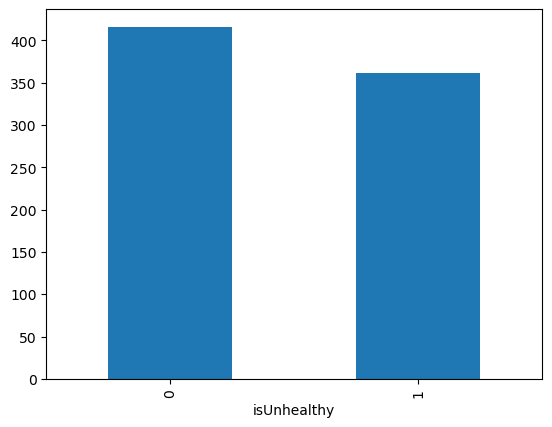

In [12]:
# Merge the NOAA GSOD weather data with our OpenAQ data by DATE...
# Perform another column drop to remove columns we don't want as features/inputs.
# This column removal will NOT be necessary once we can use Autogluon ignore_columns param (TBD).
print(AQbyWeather.selectedScenario.getSummary())
merged_df = AQbyWeather.getMergedDataFrame(noaagsod_df, aq_df)

if len(merged_df) > 0:
    # Output DataFrame properties...
    print("merged_df.shape =", merged_df.shape)
    display(merged_df)
    merged_df.groupby([AQbyWeather.mlTargetLabel]).size().plot(kind="bar")
    merged_df.to_csv(AQbyWeather.getFilenameOther("dataMERGED"), index=False)


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


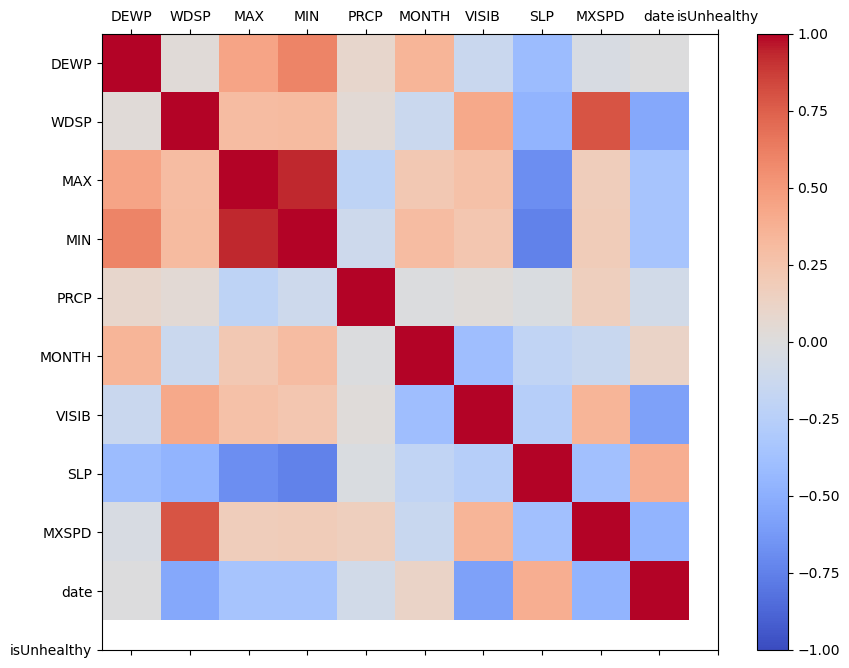

In [13]:
# Visualize correlations in our merged dataframe...
print(AQbyWeather.selectedScenario.getSummary())
correlations = merged_df.corr()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap = "coolwarm")
fig.colorbar(cax)
ticks = np.arange(0, len(merged_df.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(merged_df.columns)
ax.set_yticklabels(merged_df.columns)
plt.show()


In [14]:
# Split out train_df + validate_df data...
print(AQbyWeather.selectedScenario.getSummary())
train_df, validate_df = train_test_split(merged_df, test_size=0.2, random_state=1)
print('Number of training samples:', len(train_df))
print('Number of validation samples:', len(validate_df))


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Number of training samples: 621
Number of validation samples: 156


In [15]:
# Create the test_df data and remove the target label column...
print(AQbyWeather.selectedScenario.getSummary())
test_df = validate_df.drop([AQbyWeather.mlTargetLabel], axis=1)
display(test_df)


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,VISIB,SLP,MXSPD,date
374,29.7,5.8,70.0,35.1,0.0,1,7.2,1025.0,20.0,2022-01-28
491,44.6,5.6,102.0,68.0,0.0,5,7.8,1007.8,11.1,2022-05-25
678,35.1,2.5,53.1,30.9,0.0,12,1.7,1022.6,6.0,2022-12-23
720,41.0,3.4,61.0,35.1,0.0,2,7.0,1027.4,8.9,2023-02-08
412,35.2,3.9,64.9,37.0,0.0,3,9.8,1025.1,11.1,2022-03-07
...,...,...,...,...,...,...,...,...,...,...
323,43.2,2.9,61.0,39.9,0.0,12,2.9,1017.2,9.9,2021-12-08
331,35.4,5.0,60.1,36.0,0.0,12,8.5,1021.1,12.0,2021-12-16
703,38.0,3.5,55.0,36.0,0.0,1,5.5,1024.0,8.0,2023-01-22
159,54.2,4.6,106.0,73.0,0.0,6,8.9,1006.6,13.0,2021-06-27


In [16]:
# This section of code may take 5-10 minutes to run. Output may have red background.
# Use AutoGluon TabularPredictor to fit a model for our training data...
display(AQbyWeather.selectedScenario.getSummary()) #Using display for consistent/sequential output order.
predictor = TabularPredictor(label=AQbyWeather.mlTargetLabel, 
                             eval_metric=AQbyWeather.mlEvalMetric, 
                             path=AQbyWeather.selectedScenario.getModelPath())
predictor.fit(train_data=train_df, time_limit=AQbyWeather.mlTimeLimitSecs, verbosity=2, presets='best_quality')


'Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³'

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=6, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/aq_bakersfield_pm25_2016-2023/"
AutoGluon Version:  0.8.2
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sun Oct 22 17:17:17 UTC 2023
Disk Space Avail:   9223372034.56 GB / 9223372036.85 GB (100.0%)
Train Data Rows:    621
Train Data Columns: 10
Label Column: isUnhealthy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the

In [17]:
# Get dataframes for feature importance + model leaderboard AND get+display model evaluation...
display(AQbyWeather.selectedScenario.getSummary()) #Using display for consistent/sequential output order.
featureimp_df   = predictor.feature_importance(validate_df)
leaderboard_df  = predictor.leaderboard(validate_df, silent=True)
modelEvaluation = predictor.evaluate(validate_df, auxiliary_metrics=True)


'Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³'

Computing feature importance via permutation shuffling for 10 features using 156 rows with 5 shuffle sets...
	51.75s	= Expected runtime (10.35s per shuffle set)
	1.92s	= Actual runtime (Completed 5 of 5 shuffle sets)
Evaluation: accuracy on test data: 0.8525641025641025
Evaluations on test data:
{
    "accuracy": 0.8525641025641025,
    "balanced_accuracy": 0.8468265867066467,
    "mcc": 0.7003943733417065,
    "roc_auc": 0.9376978177577877,
    "f1": 0.8270676691729324,
    "precision": 0.859375,
    "recall": 0.7971014492753623
}


In [18]:
# View Autogluon Individual Model Leaderboard...
print(AQbyWeather.selectedScenario.getSummary())
display(leaderboard_df)


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch_BAG_L1,0.891026,0.880837,0.090388,0.109380,24.412596,0.090388,0.109380,24.412596,1,True,12
1,LightGBMLarge_BAG_L1,0.871795,0.864734,0.120735,0.023551,13.328960,0.120735,0.023551,13.328960,1,True,13
2,RandomForestGini_BAG_L1,0.865385,0.856683,0.150578,0.281981,1.071944,0.150578,0.281981,1.071944,1,True,5
3,ExtraTreesGini_BAG_L1,0.865385,0.855072,0.165368,0.209412,0.860103,0.165368,0.209412,0.860103,1,True,8
4,ExtraTreesEntr_BAG_L1,0.865385,0.863124,0.177572,0.153186,0.825262,0.177572,0.153186,0.825262,1,True,9
5,CatBoost_BAG_L1,0.858974,0.884058,0.017615,0.009502,15.142954,0.017615,0.009502,15.142954,1,True,7
6,RandomForestEntr_BAG_L1,0.858974,0.859903,0.111848,0.272961,1.096163,0.111848,0.272961,1.096163,1,True,6
7,NeuralNetFastAI_BAG_L1,0.858974,0.882448,0.277543,0.221357,23.928486,0.277543,0.221357,23.928486,1,True,10
8,LightGBMXT_BAG_L1,0.852564,0.895330,0.050212,0.015579,12.084531,0.050212,0.015579,12.084531,1,True,3
9,WeightedEnsemble_L2,0.852564,0.896940,0.071387,0.029964,28.437207,0.003560,0.004883,1.209722,2,True,14


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


,importance,stddev,p_value,n,p99_high,p99_low
VISIB,0.176923,0.040694,0.000313,5,0.260712,0.093134
MIN,0.023077,0.015438,0.014384,5,0.054864,-0.008710
WDSP,0.014103,0.020968,0.103523,5,0.057277,-0.029072
SLP,0.011538,0.007022,0.010656,5,0.025997,-0.002920
MAX,0.007692,0.008358,0.054350,5,0.024901,-0.009517
MONTH,0.005128,0.018356,0.283019,5,0.042924,-0.032667
DEWP,0.003846,0.005734,0.104000,5,0.015652,-0.007959
PRCP,0.003846,0.005734,0.104000,5,0.015652,-0.007959
MXSPD,0.002564,0.005734,0.186950,5,0.014369,-0.009241
date,-0.024359,0.007022,0.999256,5,-0.009900,-0.038818


<AxesSubplot:xlabel='feature'>

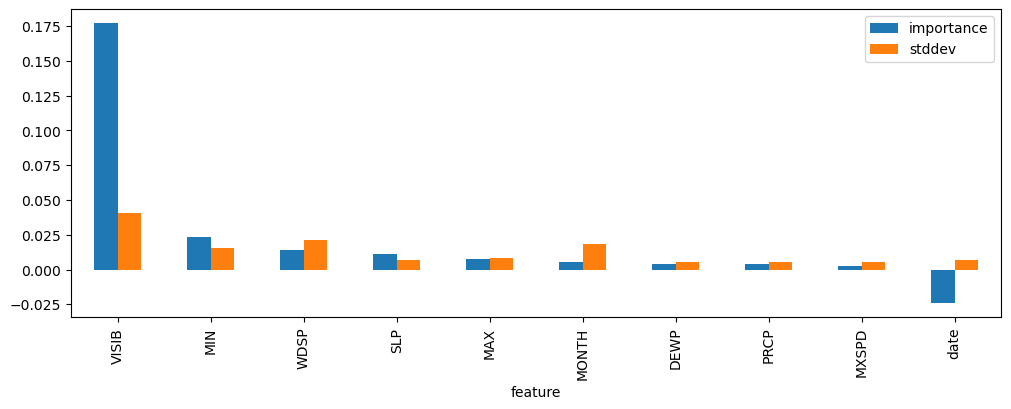

In [19]:
# View and Plot Feature Importance... (this various from Scenario to Scenario)
print(AQbyWeather.selectedScenario.getSummary())
display(featureimp_df)
featureimp_df[["importance", "stddev"]].plot(kind="bar", figsize=(12, 4), xlabel="feature")


In [20]:
# Load + Use Our Model (this line is unnecessary, but shows how to load a built model)...
predictor = TabularPredictor.load(AQbyWeather.selectedScenario.getModelPath())

# Make Predictions, which are saved to an array: y_pred
print(AQbyWeather.selectedScenario.getSummary())
y_pred = predictor.predict(test_df)
display(y_pred)


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


374    1
491    0
678    1
720    1
412    1
      ..
323    1
331    0
703    1
159    0
415    1
Name: isUnhealthy, Length: 156, dtype: int64

In [21]:
# Get true label values as an array: y_true
print(AQbyWeather.selectedScenario.getSummary())
y_true = validate_df[AQbyWeather.mlTargetLabel]
display(y_true)


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³


374    1
491    0
678    1
720    1
412    1
      ..
323    1
331    0
703    1
159    0
415    1
Name: isUnhealthy, Length: 156, dtype: int64

Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
True Negatives  (TN): 78 of 87 => 89.66%
True Positives  (TP): 55 of 69 => 79.71%
False Negatives (FN): 14 of 69 => 20.29%
False Positives (FP): 9 of 87 => 10.34%


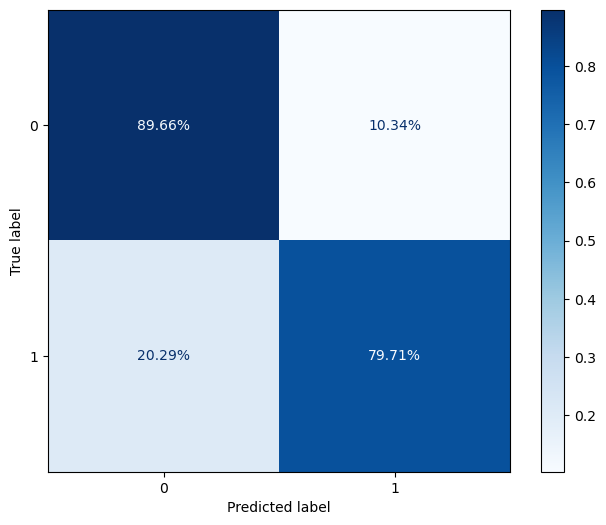

In [22]:
# Get Confusion Matrix (CM), Get Additional CM Data, View CM...
print(AQbyWeather.selectedScenario.getSummary())
cm = confusion_matrix(y_true, y_pred)

# Print Confusion Matrix data...
cmData = AQbyWeather.getConfusionMatrixData(cm)
print(cmData.TN_Output, cmData.TP_Output, cmData.FN_Output, cmData.FP_Output, sep='\n')

# Plot Confusion Matrix...
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmd = ConfusionMatrixDisplay(confusion_matrix=cmn)
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax, cmap = "Blues", values_format = '.2%')


In [23]:
# Create and save final results...
print(AQbyWeather.selectedScenario.getSummary())
resultsFile = AQbyWeather.getFilenameOther("dataRESULTS")
results_df = pd.DataFrame()
results_df["PREDICTION"] = pd.DataFrame(y_pred)
results_df = pd.concat([validate_df, results_df], axis=1)
results_df.to_csv(resultsFile, index=False)
print(f"Results saved to {resultsFile}. DONE.")
display(results_df)


Scenario: bakersfield_pm25 => Particulate Matter < 2.5 micrometers (pm25) with UnhealthyThreshold > 12.0 µg/m³
Results saved to dataRESULTS_bakersfield_pm25_2016-2023.csv. DONE.


,DEWP,WDSP,MAX,MIN,PRCP,MONTH,VISIB,SLP,MXSPD,date,isUnhealthy,PREDICTION
374,29.7,5.8,70.0,35.1,0.0,1,7.2,1025.0,20.0,2022-01-28,1,1
491,44.6,5.6,102.0,68.0,0.0,5,7.8,1007.8,11.1,2022-05-25,0,0
678,35.1,2.5,53.1,30.9,0.0,12,1.7,1022.6,6.0,2022-12-23,1,1
720,41.0,3.4,61.0,35.1,0.0,2,7.0,1027.4,8.9,2023-02-08,1,1
412,35.2,3.9,64.9,37.0,0.0,3,9.8,1025.1,11.1,2022-03-07,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
323,43.2,2.9,61.0,39.9,0.0,12,2.9,1017.2,9.9,2021-12-08,1,1
331,35.4,5.0,60.1,36.0,0.0,12,8.5,1021.1,12.0,2021-12-16,0,0
703,38.0,3.5,55.0,36.0,0.0,1,5.5,1024.0,8.0,2023-01-22,1,1
159,54.2,4.6,106.0,73.0,0.0,6,8.9,1006.6,13.0,2021-06-27,0,0
